In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import itertools
import os
import re
from pathlib import Path

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

_PRNG = np.random.RandomState(0)

In [2]:
_DATA_DIR = "./data"
_FILE_PROCESSED_DATASET = "lendingclub_2016-2018_processed.csv"
_FILE_PATH_PROCESSED_DATASET = Path(_DATA_DIR + "/" + _FILE_PROCESSED_DATASET)

_IS_PROCESSED_DATASET = False

df = None
# Read in the data, check if a preprocessed dataset exists
if _FILE_PATH_PROCESSED_DATASET.is_file():
    print("Preprocessed dataset found, reading preprocessed dataset")
    _IS_PROCESSED_DATASET = True
    df = pd.read_csv(_FILE_PATH_PROCESSED_DATASET)
else:
    # Read all data
    print("Preprocessed dataset not found, reading all data")
    _dataset_loan_columns = ["loan_amnt",
                             "int_rate",
                             "term",
                             "grade",
                             "sub_grade",
                             "installment",
                             "annual_inc",
                             "loan_status",
                             "verification_status",
                             "purpose"]

    dataset_loans = {}
    for file_name in os.listdir(_DATA_DIR):
        if file_name.endswith(".csv"):
            full_file_path = _DATA_DIR + "/" + file_name
            print(full_file_path)
            loan_period = re.search(r'\d{4}Q[0-4]{1}', file_name).group(0)
            dataset_loans[loan_period] = pd.read_csv(full_file_path, usecols=_dataset_loan_columns)[_dataset_loan_columns]
    
    # Combine all the data into a single dataframe
    print("Combining all the data into a single dataframe")
    for k, dataset in dataset_loans.items():
        if df is None:
            df = dataset
            continue
        df = df.append(dataset, ignore_index=True)

    del dataset_loans
        
    # Convert column types
    print("Converting column types")
    df["loan_amnt"] = df["loan_amnt"].astype(int)
    df["annual_inc"] = df["annual_inc"].astype(int)
    df["int_rate"] = df["int_rate"].apply(lambda int_rate: float(int_rate[:-1]))
    df["term"] = df["term"].apply(lambda term: int(re.search(r'\d+', term).group(0)))
    
    # Remove outliers
    # Annual income must be greater than 0 and less than 1 million
    # Assume 0 is an outlier
    # Assume millioniare+ are outliers
    print("Removing outliers")
    df = df.loc[(df["annual_inc"] > 0) & (df["annual_inc"] < 1000000)]
    
    # Convert non-ordinal categorical variables to binary vectors
    print("Convert non-ordinal categorical variables to binary vectors (this can take a while)")
    total_columns_to_process = len(df["verification_status"].unique()) + len(df["purpose"].unique())
    columns_processed = 0
    for verification_status in df["verification_status"].unique():
        columns_processed += 1
        print(f"[{columns_processed}/{total_columns_to_process}]", verification_status)
        df["vs_" + verification_status] = df.apply(lambda row: int(row["verification_status"] == verification_status), axis=1)
    for purpose in df["purpose"].unique():
        columns_processed += 1
        print(f"[{columns_processed}/{total_columns_to_process}]", purpose)
        df["p_" + purpose] = df.apply(lambda row: int(row["purpose"] == purpose), axis=1)

    df.drop(columns=["verification_status"], inplace=True)
    df.drop(columns=["purpose"], inplace=True)
    
    # Save processed dataset for future use
    print("Saving processed dataset")
    df.to_csv(_FILE_PATH_PROCESSED_DATASET, index=False, header=True)
    
print("Done!")

Preprocessed dataset found, reading preprocessed dataset
Done!


In [3]:
print("Number of loans in combined dataset:", len(df))
df.head(5)

Number of loans in combined dataset: 1371066


,loan_amnt,int_rate,term,grade,sub_grade,installment,annual_inc,loan_status,vs_Source Verified,vs_Verified,...,p_other,p_major_purchase,p_vacation,p_moving,p_medical,p_car,p_house,p_renewable_energy,p_wedding,p_educational
0,5000,17.27,36,D,D2,178.94,62000,Fully Paid,1,0,...,0,0,0,0,0,0,0,0,0,0
1,22000,6.49,36,A,A2,674.18,134000,Current,0,1,...,0,0,0,0,0,0,0,0,0,0
2,30000,10.75,60,B,B4,648.54,125000,Fully Paid,0,1,...,0,0,0,0,0,0,0,0,0,0
3,10000,16.29,36,D,D1,353.01,40000,Charged Off,1,0,...,0,0,0,0,0,0,0,0,0,0
4,12000,9.75,36,B,B3,385.80,120000,Current,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
# Check if we have any null values
df[df.isnull().any(axis=1)]

,loan_amnt,int_rate,term,grade,sub_grade,installment,annual_inc,loan_status,vs_Source Verified,vs_Verified,...,p_other,p_major_purchase,p_vacation,p_moving,p_medical,p_car,p_house,p_renewable_energy,p_wedding,p_educational


### Preprocessing

In [5]:
# Convert ordinal categorical variables to numerical
le_grade = LabelEncoder()
df["grade"] = le_grade.fit_transform(df["grade"])

le_sub_grade = LabelEncoder()
df["sub_grade"] = le_sub_grade.fit_transform(df["sub_grade"])

In [6]:
# Separate the postive/negative class
df_pos = df.loc[df["loan_status"] == "Fully Paid"]
df_neg = df.loc[(df["loan_status"] == "Default") | (df["loan_status"] == "Charged Off")]

In [7]:
df_pos["loan_status"].value_counts()

Fully Paid    382014
Name: loan_status, dtype: int64

In [8]:
df_neg["loan_status"].value_counts()

Charged Off    108758
Default            35
Name: loan_status, dtype: int64

In [9]:
df_pos[["loan_amnt", "int_rate", "term", "grade", "sub_grade", "installment", "annual_inc"]].corr()

,loan_amnt,int_rate,term,grade,sub_grade,installment,annual_inc
loan_amnt,1.000000,0.117732,0.353937,0.114210,0.116027,0.958982,0.422926
int_rate,0.117732,1.000000,0.368597,0.962965,0.987197,0.155487,-0.099715
term,0.353937,0.368597,1.000000,0.357490,0.366070,0.136393,0.079493
grade,0.114210,0.962965,0.357490,1.000000,0.971276,0.148621,-0.099893
sub_grade,0.116027,0.987197,0.366070,0.971276,1.000000,0.151058,-0.108120
installment,0.958982,0.155487,0.136393,0.148621,0.151058,1.000000,0.403238
annual_inc,0.422926,-0.099715,0.079493,-0.099893,-0.108120,0.403238,1.000000


In [10]:
df_neg[["loan_amnt", "int_rate", "term", "grade", "sub_grade", "installment", "annual_inc"]].corr()

,loan_amnt,int_rate,term,grade,sub_grade,installment,annual_inc
loan_amnt,1.000000,0.191178,0.387081,0.187644,0.193173,0.945589,0.450970
int_rate,0.191178,1.000000,0.376418,0.962659,0.983896,0.248679,-0.066134
term,0.387081,0.376418,1.000000,0.372196,0.383811,0.142168,0.109504
grade,0.187644,0.962659,0.372196,1.000000,0.975763,0.238671,-0.068205
sub_grade,0.193173,0.983896,0.383811,0.975763,1.000000,0.244191,-0.070253
installment,0.945589,0.248679,0.142168,0.238671,0.244191,1.000000,0.419332
annual_inc,0.450970,-0.066134,0.109504,-0.068205,-0.070253,0.419332,1.000000


In [11]:
# Take a random even subsample
SUBSAMPLE_AMOUNT = 100000

# The validation set has a similar ratio of pos/neg as the original dataset, ~ 3.5 pos : 1 neg
VALIDATION_POSITIVE_AMOUNT = 28000
VALIDATION_NEGATIVE_AMOUNT = 8000

df_pos = df_pos.sample(n=SUBSAMPLE_AMOUNT + VALIDATION_POSITIVE_AMOUNT, replace=False, random_state=_PRNG)
df_neg = df_neg.sample(n=SUBSAMPLE_AMOUNT + VALIDATION_NEGATIVE_AMOUNT, replace=False, random_state=_PRNG)

df_pos.drop(columns=["loan_status"], inplace=True)
df_neg.drop(columns=["loan_status"], inplace=True)

# Fit scalars
data_to_scale = pd.concat([df_pos, df_neg], ignore_index=True, copy=True).astype(float)
minmax_scaler = MinMaxScaler(feature_range=(0, 1))
minmax_scaler.fit(data_to_scale)
standard_scaler = StandardScaler()
standard_scaler.fit(data_to_scale)
del data_to_scale

# Shuffle before taking our validation set
df_pos = df_pos.sample(frac=1).reset_index(drop=True)
df_neg = df_neg.sample(frac=1).reset_index(drop=True)

# Validation set used later to calculate profitability
df_val_pos = df_pos.tail(VALIDATION_POSITIVE_AMOUNT)
df_val_neg = df_neg.tail(VALIDATION_NEGATIVE_AMOUNT)

df_val_pos.reset_index(drop=True, inplace=True)
df_val_neg.reset_index(drop=True, inplace=True)

df_pos.drop(df_pos.tail(VALIDATION_POSITIVE_AMOUNT).index, inplace=True)
df_neg.drop(df_neg.tail(VALIDATION_NEGATIVE_AMOUNT).index, inplace=True)

print("Subsample pos:", len(df_pos))
print("Subsample neg:", len(df_neg))

Subsample pos: 100000
Subsample neg: 100000


In [12]:
# Combine subsamples
df_subsample_X = pd.concat([df_pos, df_neg], ignore_index=True, copy=True)
df_subsample_X = df_subsample_X.astype(float)
df_subsample_Y = [1] * len(df_pos) + [0] * len(df_neg)

assert len(df_subsample_X) == len(df_subsample_Y), "Dataset and labels must be the same size"

In [13]:
CLASSIFIERS = {}

In [14]:
class ClassifierInfo:
    def __init__(self, classifier, scaler, training_score:float, test_score:float) -> None:
        self.classifier = classifier
        self.scaler = scaler
        self.training_score = training_score
        self.test_score = test_score
    
    def predict(self, row) -> float:
        return self.classifier.predict_proba(self.scaler.transform(row))

### Linear SVM

In [15]:
# Most libraries recommend a hard normalization, mapping the min and max values of a given dimension to [0,1]
# However, a soft normalization is also feasible using StandardScaler
# https://neerajkumar.org/writings/svm/
# https://www.csie.ntu.edu.tw/~cjlin/papers/guide/guide.pdf

scaler = minmax_scaler
# scaler = standard_scaler

df_subsample_scaled_X = scaler.fit_transform(df_subsample_X)

In [16]:
# Create train/test split
# The training set is much smaller due to computation constraints, SVMs have poor scalability
X_train, X_test, Y_train, Y_test = train_test_split(df_subsample_scaled_X, df_subsample_Y, train_size=0.1, test_size=0.2, stratify=df_subsample_Y, random_state=_PRNG)
print("Training set size:", len(X_train))
print("Training label size:", len(Y_train))
print("Test set size:", len(X_test))
print("Test label size:", len(Y_test))

Training set size: 20000
Training label size: 20000
Test set size: 40000
Test label size: 40000


In [17]:
# Use grid search cross-validation to find the best C, using F1-score
parameters = {
    "C" : [2 ** power for power in range(-5, 9)]
}

parameters = {
    "C" : [0.0625]
}

clf = GridSearchCV(SVC(kernel="linear", cache_size=4000, probability=True, random_state=_PRNG), param_grid=parameters, scoring="f1", cv=5, refit=True, n_jobs=-1, verbose=1)
clf.fit(X_train, Y_train)
print (clf.best_score_, clf.best_params_)
clf.best_estimator_

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  2.7min remaining:  4.0min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  2.7min finished


0.6431594874176584 {'C': 0.0625}


SVC(C=0.0625, cache_size=4000, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='linear', max_iter=-1, probability=True,
  random_state=<mtrand.RandomState object at 0x000002081C661E10>,
  shrinking=True, tol=0.001, verbose=False)

In [18]:
svm = clf.best_estimator_

test_score = svm.score(X_test, Y_test)
test_score

0.634675

In [19]:
CLASSIFIERS["svm"] = ClassifierInfo(classifier=svm, scaler=scaler, training_score=clf.best_score_, test_score=test_score)

In [20]:
for col_name, value in zip(df_pos.columns, svm.coef_.ravel()):
    print("{:20s} : {:.4f}".format(col_name, value))

loan_amnt            : -0.3176
int_rate             : -0.2208
term                 : -0.3545
grade                : -1.3855
sub_grade            : -1.7395
installment          : -0.1815
annual_inc           : 1.7303
vs_Source Verified   : -0.0002
vs_Verified          : -0.1952
vs_Not Verified      : 0.1955
p_credit_card        : 0.0371
p_debt_consolidation : 0.0549
p_small_business     : -0.3125
p_home_improvement   : 0.0370
p_other              : 0.0625
p_major_purchase     : -0.1914
p_vacation           : 0.2459
p_moving             : -0.0625
p_medical            : -0.2601
p_car                : 0.2016
p_house              : 0.0000
p_renewable_energy   : 0.1875
p_wedding            : 0.0000
p_educational        : 0.0000


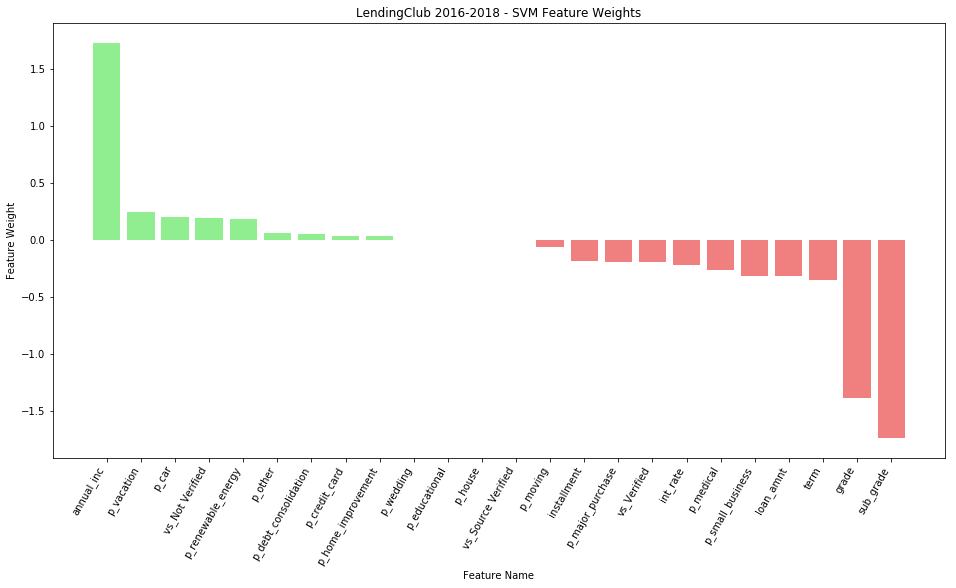

In [21]:
# Plot SVM feature weights
coef = svm.coef_.ravel()
coef_sorted = np.argsort(coef)[::-1]

col = list(df_pos.columns)
colors = ["lightcoral" if feature_weight < 0 else "lightgreen" for feature_weight in coef[coef_sorted]]

plt.figure(figsize=(16, 8))
plt.bar(list(range(len(coef))), coef[coef_sorted], color=colors)
plt.xticks(np.arange(0, len(coef)), [col[idx] for idx in coef_sorted], rotation=60, ha="right")
plt.xlabel("Feature Name")
plt.ylabel("Feature Weight")
plt.title("LendingClub 2016-2018 - SVM Feature Weights")
plt.savefig("res/Prediction/SVM - Feature Weights.png", bbox_inches='tight')
plt.show()

In [22]:
svm.predict_proba(X_test[:10])

array([[0.31120272, 0.68879728],
       [0.48345192, 0.51654808],
       [0.31427393, 0.68572607],
       [0.39740376, 0.60259624],
       [0.52412088, 0.47587912],
       [0.42866196, 0.57133804],
       [0.41065934, 0.58934066],
       [0.27433844, 0.72566156],
       [0.37761838, 0.62238162],
       [0.55582077, 0.44417923]])

### Decision Tree

In [23]:
# scaler = minmax_scaler
scaler = standard_scaler

df_subsample_scaled_X = scaler.fit_transform(df_subsample_X)

In [24]:
# Create train/test split
X_train, X_test, Y_train, Y_test = train_test_split(df_subsample_scaled_X, df_subsample_Y, test_size=0.125, stratify=df_subsample_Y, random_state=_PRNG)
print("Training set size:", len(X_train))
print("Training label size:", len(Y_train))
print("Test set size:", len(X_test))
print("Test label size:", len(Y_test))

Training set size: 175000
Training label size: 175000
Test set size: 25000
Test label size: 25000


In [25]:
# Use random search to find best hyperparameters
parameters = {
    "max_depth"             : range(1, 31),
    "min_samples_split"     : range(2, 21),
    "min_samples_leaf"      : range(1, 11),
    "max_features"          : ["sqrt", "log2", None]
}

parameters = {
    "max_depth"             : range(10, 11),
    "max_features"          : ["sqrt"]
}

clf = RandomizedSearchCV(DecisionTreeClassifier(criterion="gini", random_state=_PRNG), param_distributions=parameters, n_iter=250, scoring="f1", cv=5, refit=True, n_jobs=-1, random_state=_PRNG, verbose=1)
clf.fit(X_train, Y_train)

print(clf.best_score_, clf.best_params_)
clf.best_estimator_

Fitting 5 folds for each of 1 candidates, totalling 5 fits


C:\Users\juszhan\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:271: UserWarning: The total space of parameters 1 is smaller than n_iter=250. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    1.4s remaining:    2.1s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.7s finished


0.6200375661036909 {'max_features': 'sqrt', 'max_depth': 10}


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=10,
            max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False,
            random_state=<mtrand.RandomState object at 0x000002081BF37990>,
            splitter='best')

In [26]:
decision_tree = clf.best_estimator_

test_score =decision_tree.score(X_test, Y_test)
test_score

0.63652

In [27]:
CLASSIFIERS["decision_tree"] = ClassifierInfo(classifier=decision_tree, scaler=scaler, training_score=clf.best_score_, test_score=test_score)

In [28]:
decision_tree.predict_proba(X_train[:10])

array([[0.36026381, 0.63973619],
       [0.5940246 , 0.4059754 ],
       [0.60296846, 0.39703154],
       [0.49319307, 0.50680693],
       [0.53761336, 0.46238664],
       [0.42033898, 0.57966102],
       [0.62757165, 0.37242835],
       [0.26035503, 0.73964497],
       [0.6612426 , 0.3387574 ],
       [0.80269058, 0.19730942]])

### RandomForest

In [29]:
# scaler = minmax_scaler
scaler = standard_scaler

df_subsample_scaled_X = scaler.fit_transform(df_subsample_X)

In [30]:
# Create train/test split
X_train, X_test, Y_train, Y_test = train_test_split(df_subsample_scaled_X, df_subsample_Y, test_size=0.125, stratify=df_subsample_Y, random_state=_PRNG)
print("Training set size:", len(X_train))
print("Training label size:", len(Y_train))
print("Test set size:", len(X_test))
print("Test label size:", len(Y_test))

Training set size: 175000
Training label size: 175000
Test set size: 25000
Test label size: 25000


In [31]:
# Use random search to find best hyperparameters
parameters = {
    "n_estimators"          : range(100, 200, 10),
    "max_depth"             : range(1, 31),
    "min_samples_split"     : range(2, 21),
    "min_samples_leaf"      : range(1, 11),
    "max_features"          : ["sqrt", "log2", None]
}

parameters = {
    "n_estimators"          : range(100, 101),
    "max_depth"             : range(25, 26),
    "min_samples_split"     : range(16, 17),
    "min_samples_leaf"      : range(1, 2),
    "max_features"          : ["log2"]
}

clf = RandomizedSearchCV(RandomForestClassifier(criterion="gini", n_jobs=-1, random_state=_PRNG), param_distributions=parameters, n_iter=250, scoring="f1", cv=5, refit=True, n_jobs=-1, random_state=_PRNG, verbose=1)

clf.fit(X_train, Y_train)

print(clf.best_score_, clf.best_params_)
clf.best_estimator_

Fitting 5 folds for each of 1 candidates, totalling 5 fits


C:\Users\juszhan\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:271: UserWarning: The total space of parameters 1 is smaller than n_iter=250. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   23.2s remaining:   34.8s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   25.1s finished


0.6254778050951068 {'n_estimators': 100, 'min_samples_split': 16, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': 25}


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=25, max_features='log2', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=16,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
            oob_score=False,
            random_state=<mtrand.RandomState object at 0x000002081BF749D8>,
            verbose=0, warm_start=False)

In [32]:
random_forest = clf.best_estimator_

test_score = random_forest.score(X_test, Y_test)
test_score

0.64136

In [33]:
CLASSIFIERS["random_forest"] = ClassifierInfo(classifier=random_forest, scaler=scaler, training_score=clf.best_score_, test_score=test_score)

In [34]:
random_forest.predict_proba(X_train[:10])

array([[0.35588593, 0.64411407],
       [0.41882885, 0.58117115],
       [0.37666542, 0.62333458],
       [0.38965749, 0.61034251],
       [0.45729893, 0.54270107],
       [0.70414065, 0.29585935],
       [0.30744603, 0.69255397],
       [0.60274571, 0.39725429],
       [0.63923009, 0.36076991],
       [0.50310156, 0.49689844]])

### Gradient Boosting

In [35]:
# scaler = minmax_scaler
scaler = standard_scaler

df_subsample_scaled_X = scaler.fit_transform(df_subsample_X)

In [36]:
# Create train/test split
X_train, X_test, Y_train, Y_test = train_test_split(df_subsample_scaled_X, df_subsample_Y, test_size=0.125, stratify=df_subsample_Y, random_state=_PRNG)
print("Training set size:", len(X_train))
print("Training label size:", len(Y_train))
print("Test set size:", len(X_test))
print("Test label size:", len(Y_test))

Training set size: 175000
Training label size: 175000
Test set size: 25000
Test label size: 25000


In [37]:
# Use random search to find best hyperparameters
parameters = {
    "learning_rate"         : np.arange(.001, .2, 0.002),
    "max_depth"             : range(1, 31),
    "min_samples_split"     : range(2, 21),
    "min_samples_leaf"      : range(1, 11),
    "max_depth"             : range(3, 10),
    "max_features"          : ["sqrt", "log2", None]
}

parameters = {
    "max_features"          : ["sqrt"]
}

clf = RandomizedSearchCV(GradientBoostingClassifier(loss="deviance", n_estimators=100, random_state=_PRNG, n_iter_no_change=30, validation_fraction=0.1, tol=1e-4), param_distributions=parameters, n_iter=250, scoring="f1", cv=5, refit=True, n_jobs=-1, random_state=_PRNG, verbose=1)

clf.fit(X_train, Y_train)

print(clf.best_score_, clf.best_params_)
clf.best_estimator_

Fitting 5 folds for each of 1 candidates, totalling 5 fits


C:\Users\juszhan\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:271: UserWarning: The total space of parameters 1 is smaller than n_iter=250. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   12.5s remaining:   18.8s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   12.7s finished


0.6277971651876851 {'max_features': 'sqrt'}


GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features='sqrt', max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              n_iter_no_change=30, presort='auto',
              random_state=<mtrand.RandomState object at 0x000002081C0145E8>,
              subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False)

In [38]:
gradient_boosting = clf.best_estimator_

test_score = gradient_boosting.score(X_test, Y_test)
test_score

0.64104

In [39]:
CLASSIFIERS["gradient_boosting"] = ClassifierInfo(classifier=gradient_boosting, scaler=scaler, training_score=clf.best_score_, test_score=test_score)

In [40]:
gradient_boosting.predict_proba(X_train[:10])

array([[0.51897415, 0.48102585],
       [0.49693327, 0.50306673],
       [0.50377527, 0.49622473],
       [0.46239358, 0.53760642],
       [0.48426113, 0.51573887],
       [0.29017407, 0.70982593],
       [0.56728173, 0.43271827],
       [0.59712783, 0.40287217],
       [0.59832287, 0.40167713],
       [0.56153927, 0.43846073]])

### Calculating Profitability

In [41]:
# df_val_pos
# df_val_neg

df_val_pos.iloc[0]

loan_amnt               24000.00
int_rate                   10.42
term                       60.00
grade                       1.00
sub_grade                   7.00
installment               514.91
annual_inc              80000.00
vs_Source Verified          0.00
vs_Verified                 0.00
vs_Not Verified             1.00
p_credit_card               0.00
p_debt_consolidation        1.00
p_small_business            0.00
p_home_improvement          0.00
p_other                     0.00
p_major_purchase            0.00
p_vacation                  0.00
p_moving                    0.00
p_medical                   0.00
p_car                       0.00
p_house                     0.00
p_renewable_energy          0.00
p_wedding                   0.00
p_educational               0.00
Name: 0, dtype: float64

In [42]:
df_val_pos.head(5)

,loan_amnt,int_rate,term,grade,sub_grade,installment,annual_inc,vs_Source Verified,vs_Verified,vs_Not Verified,...,p_other,p_major_purchase,p_vacation,p_moving,p_medical,p_car,p_house,p_renewable_energy,p_wedding,p_educational
0,24000,10.42,60,1,7,514.91,80000,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,15000,7.89,36,0,4,469.29,72924,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2,22000,12.74,36,2,10,738.52,100000,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,10000,12.99,36,2,11,336.90,20000,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4000,14.08,36,2,12,136.87,50000,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [43]:
df_val_neg.head(5)

,loan_amnt,int_rate,term,grade,sub_grade,installment,annual_inc,vs_Source Verified,vs_Verified,vs_Not Verified,...,p_other,p_major_purchase,p_vacation,p_moving,p_medical,p_car,p_house,p_renewable_energy,p_wedding,p_educational
0,4000,16.99,36,3,15,142.60,38000,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1,9500,13.99,36,2,12,324.65,45000,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,8000,11.49,36,1,9,263.78,60000,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3,16000,11.49,36,1,9,527.55,120000,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,22550,18.06,36,3,16,815.92,86000,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [44]:
CLASSIFIERS["svm"].predict([df_val_pos.iloc[2]])

array([[0.47149045, 0.52850955]])

In [45]:
CLASSIFIERS["svm"].predict([df_val_neg.iloc[1]])

array([[0.44491096, 0.55508904]])

In [46]:
CLASSIFIERS["svm"].classifier.classes_

array([0, 1])

In [52]:
# Create the dataframe that will be used to calculate profitability
df_predict = pd.concat([df_val_pos, df_val_neg], ignore_index=True, copy=True)
df_predict = df_predict[["loan_amnt", "int_rate", "term", "grade", "sub_grade", "installment", "annual_inc"]]
df_predict["true_class"] = [1] * len(df_val_pos) + [0] * len(df_val_neg)
df_predict

,loan_amnt,int_rate,term,grade,sub_grade,installment,annual_inc,true_class
0,24000,10.42,60,1,7,514.91,80000,1
1,15000,7.89,36,0,4,469.29,72924,1
2,22000,12.74,36,2,10,738.52,100000,1
3,10000,12.99,36,2,11,336.90,20000,1
4,4000,14.08,36,2,12,136.87,50000,1
5,9000,5.32,36,0,0,271.04,62500,1
6,5600,7.91,36,0,4,175.26,38000,1
7,10000,9.16,36,1,6,318.75,129115,1
8,1400,15.05,36,2,13,48.57,60000,1
9,28800,12.74,36,2,10,966.79,60000,1
